<a href="https://colab.research.google.com/github/cbuie/colab/blob/master/airbnb/models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modeling

## Illustrative Guide to modeling variable importance with Airbnb pricing data.

## Preporocessing the raw data
**The Purpose of this notebook is to construct a repetative data preprocessing pipeline. This notebook can be used to run any city from the Airbnb data set and produce the same/similar (some features may not be relavant for certain locations, e.g. zipcode is not relevant to London) data output for modeling pricing.**
<hr>

### Load Dependencies

In [0]:
pip install catboost

In [0]:
# Importing required libraries
import pandas as pd
import numpy as np
from numpy.random import seed
seed(123)
from IPython.core.display import HTML
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
import xgboost as xgb
from xgboost import plot_importance
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score, mean_absolute_error
import time
from keras import models, layers, optimizers, regularizers
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
import catboost
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
plt.style.use('dark_background')
plt.rcParams.update({
    "lines.color": "white",
    "patch.edgecolor": "white",
    "text.color": "white",
    "axes.facecolor": "#383838",
    "axes.edgecolor": "lightgray",
    "axes.labelcolor": "white",
    "xtick.color": "white",
    "ytick.color": "white",
    "grid.color": "lightgray",
    "figure.facecolor": "#383838",
    "figure.edgecolor": "#383838",
    })
%matplotlib inline
%tensorflow_version 1.x

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
df = pd.read_csv('/content/drive/My Drive/data/processed_data/processed_dummy.csv',low_memory=False, index_col='id')

### Final Review

In [0]:
df.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84165 entries, 11551 to 39869282
Data columns (total 122 columns):
host_is_superhost                                  84165 non-null float64
host_listings_count                                84165 non-null float64
host_identity_verified                             84165 non-null float64
latitude                                           84165 non-null float64
longitude                                          84165 non-null float64
accommodates                                       84165 non-null int64
bathrooms                                          84165 non-null float64
bedrooms                                           84165 non-null float64
beds                                               84165 non-null float64
price                                              84165 non-null int64
security_deposit                                   84165 non-null int64
cleaning_fee                                       84165 non-null int64
gue

In [0]:
df.head()

,host_is_superhost,host_listings_count,host_identity_verified,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_90,number_of_reviews,number_of_reviews_ltm,instant_bookable,host_days_active,check_in_24h,air_conditioning,high_end_electronics,bbq,balcony,bed_linen,breakfast,tv,coffee_machine,cooking_basics,white_goods,elevator,child_friendly,parking,outdoor_space,host_greeting,internet,long_term_stays,pets_allowed,...,neighbourhood_cleansed_Waltham Forest,neighbourhood_cleansed_Wandsworth,neighbourhood_cleansed_Westminster,property_type_Apartment,property_type_House,property_type_Other,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,review_scores_rating_0-79/100,review_scores_rating_80-94/100,review_scores_rating_95-100/100,review_scores_rating_nan,review_scores_accuracy_0-8/10,review_scores_accuracy_10/10,review_scores_accuracy_9/10,review_scores_accuracy_nan,review_scores_cleanliness_0-8/10,review_scores_cleanliness_10/10,review_scores_cleanliness_9/10,review_scores_cleanliness_nan,review_scores_value_0-8/10,review_scores_value_10/10,review_scores_value_9/10,review_scores_value_nan,cancellation_policy_flexible,cancellation_policy_luxury_super_strict_95,cancellation_policy_moderate,cancellation_policy_strict_14_with_grace_period,time_since_first_review_0-6 months,time_since_first_review_1-2 years,time_since_first_review_2-3 years,time_since_first_review_4+ years,time_since_first_review_6-12 months,time_since_first_review_nan,time_since_last_review_1+ year,time_since_last_review_2-6 months,time_since_last_review_6-12 months,time_since_last_review_nan
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
11551,1.0,3.0,1.0,51.46225,-0.11732,4,1.0,1.0,1.0,88,400,30,2,20,3,180,61,185,2,1,3797.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0
38151,0.0,1.0,0.0,51.41940,-0.08722,2,1.0,1.0,1.0,65,0,0,1,0,1,730,90,0,0,0,3516.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1
13913,0.0,4.0,0.0,51.56802,-0.11121,2,1.0,1.0,0.0,65,100,15,1,15,1,29,90,19,5,0,3753.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,...,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0
38407,0.0,1.0,0.0,51.49995,-0.02624,2,1.0,1.0,1.0,79,0,0,2,0,2,365,0,137,0,1,3515.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0
90700,0.0,2.0,0.0,51.51074,-0.19853,2,1.0,1.0,1.0,105,0,35,2,10,2,1125,24,339,33,1,3246.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0


### Collinearity Check

In [0]:
def multi_collinearity_heatmap(df, figsize=(11,9)):
    
    """
    Creates a heatmap of correlations between features in the df. A figure size can optionally be set.
    """
    
    # Set the style of the visualization
    # sns.set(style="white")

    # Create a covariance matrix
    corr = df.corr()

    # Generate a mask the size of our covariance matrix
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=figsize)

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linecolor="", linewidths=.001, cbar_kws={"shrink": .5}, vmax=corr[corr != 1.0].max().max());

In [0]:
# multi_collinearity_heatmap(df, figsize=(14,14))

In [0]:
# df.select_dtypes(include='number').hist(figsize=(20,20));

In [0]:
# # Dropping collinear features
# to_drop = ['beds',
#            'bedrooms',
#            'guests_included', 
#            'host_response_rate_unknown',
#            'host_response_rate_0-49%',
#            'property_type_Apartment',
#            'room_type_Private room']
# to_drop.extend(list(transformed_df.columns[transformed_df.columns.str.endswith('nan')]))

# transformed_df.drop(to_drop, axis=1, inplace=True)

In [0]:
df.describe()

,host_is_superhost,host_listings_count,host_identity_verified,latitude,longitude,accommodates,bathrooms,bedrooms,beds,price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,availability_90,number_of_reviews,number_of_reviews_ltm,instant_bookable,host_days_active,check_in_24h,air_conditioning,high_end_electronics,bbq,balcony,bed_linen,breakfast,tv,coffee_machine,cooking_basics,white_goods,elevator,child_friendly,parking,outdoor_space,host_greeting,internet,long_term_stays,pets_allowed,...,neighbourhood_cleansed_Waltham Forest,neighbourhood_cleansed_Wandsworth,neighbourhood_cleansed_Westminster,property_type_Apartment,property_type_House,property_type_Other,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,review_scores_rating_0-79/100,review_scores_rating_80-94/100,review_scores_rating_95-100/100,review_scores_rating_nan,review_scores_accuracy_0-8/10,review_scores_accuracy_10/10,review_scores_accuracy_9/10,review_scores_accuracy_nan,review_scores_cleanliness_0-8/10,review_scores_cleanliness_10/10,review_scores_cleanliness_9/10,review_scores_cleanliness_nan,review_scores_value_0-8/10,review_scores_value_10/10,review_scores_value_9/10,review_scores_value_nan,cancellation_policy_flexible,cancellation_policy_luxury_super_strict_95,cancellation_policy_moderate,cancellation_policy_strict_14_with_grace_period,time_since_first_review_0-6 months,time_since_first_review_1-2 years,time_since_first_review_2-3 years,time_since_first_review_4+ years,time_since_first_review_6-12 months,time_since_first_review_nan,time_since_last_review_1+ year,time_since_last_review_2-6 months,time_since_last_review_6-12 months,time_since_last_review_nan
count,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,8.416500e+04,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,...,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000,84165.000000
mean,0.149504,27.283538,0.357702,51.509825,-0.128150,3.189426,1.298313,1.404836,1.741128,113.491368,111.960874,32.215767,1.614923,7.417264,4.042904,1.391633e+04,33.058932,17.561611,6.733512,0.434112,1562.377128,0.064385,0.057530,0.013830,0.031557,0.121428,0.357797,0.131658,0.690180,0.188962,0.321701,0.866382,0.224785,0.304046,0.397671,0.118981,0.186930,0.964189,0.218678,0.108976,...,0.016943,0.050342,0.111626,0.688528,0.248904,0.062568,0.554660,0.013129,0.424785,0.007426,0.083515,0.286639,0.377069,0.252777,0.069494,0.507028,0.170071,0.253407,0.121286,0.413272,0.212202,0.253241,0.104081,0.374811,0.267142,0.253965,0.322212,0.000036,0.236274,0.441478,0.074520,0.193394,0.241169,0.113432,0.143682,0.233803,0.214068,0.389806,0.162324,0.233803
std,0.356587,143.486332,0.479327,0.046416,0.093189,2.003683,0.595725,0.902177,1.255555,114.311591,185.784608,42.283474,1.338131,13.820571,15.598156,3.464302e+06,33.668907,36.921518,12.801745,0.495643,800.268335,0.245440,0.232854,0.116786,0.174819,0.326626,0.479355,0.338121,0.462422,0.391481,0.467132,0.340244,0.417443,0.460005,0.489420,0.323768,0.389858,0.185819,0.413352,0.311611,...,0.129058,0.218650,0.314908,0.463098,0.432381,0.242185,0.497006,0.113828,0.494313,0.085

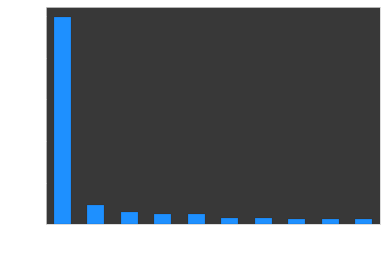

In [0]:
df.maximum_nights.value_counts(ascending=False)[:10].plot(kind='bar',color='dodgerblue', linewidth=0.1, edgecolor='k');
# df.drop(['minimum_nights','maximum_nights'], axis=1,inplace=True)

In [0]:
numerical_columns = ['accommodates', 'availability_90', 'bathrooms', 'cleaning_fee', 'extra_people', 'host_days_active', 'host_listings_count', 'maximum_nights', 'minimum_nights', 'number_of_reviews', 'price', 'security_deposit']

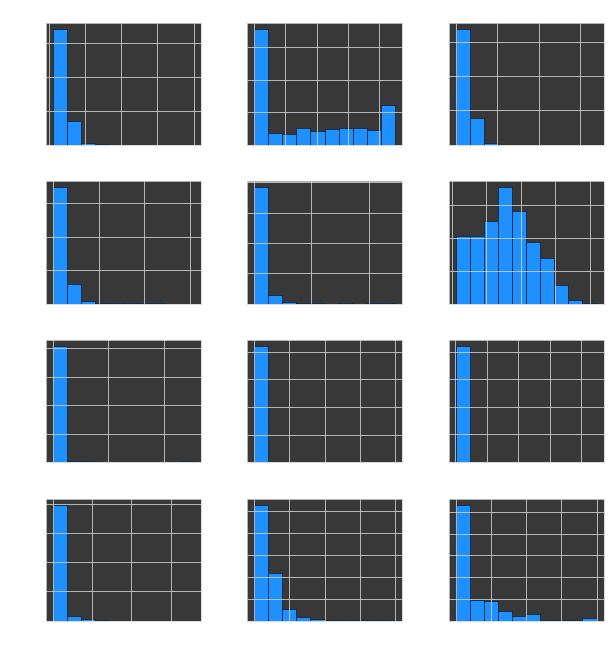

In [0]:
df[numerical_columns].hist(figsize=(10,11),color='dodgerblue',linewidth=0.5, edgecolor='k');

### Transform

In [0]:
# Log transforming columns
numerical_columns = [i for i in numerical_columns if i not in ['availability_90', 'price','host_days_active']] # Removing items not to be transformed

for col in numerical_columns:
    df[col] = df[col].astype('float64').replace(0.0, 0.01) # Replacing 0s with 0.01
    df[col] = np.log(df[col])

In [0]:
df.drop(['host_listings_count', 'maximum_nights','minimum_nights'],axis=1,inplace=True)

In [0]:
# Separating X and y
df=df.dropna()

X = df.drop('price', axis=1)
y = df.price

# Scaling
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=list(X.columns))

## Split Data Train/Test

In [0]:
# Splitting into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=95)

HTML('<h2>Response Variavble test set: <font color="red">{0}</font> <br> Response Variavble train set: <font color="red">{1}</font></h2>'.format(len(y_test),len(y_train)))

## Multivariate Regression

In [0]:
import statsmodels.api as sm

y = y_train.values
X = X_train
MVR = sm.OLS(y, X).fit()
predictions = MVR.predict(X_test) # make the predictions by the model


### Review Regression Summary

In [0]:
# Print out the statistics
MVR.summary()
# MVR.params

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.239
Model:                            OLS   Adj. R-squared (uncentered):              0.238
Method:                 Least Squares   F-statistic:                              203.5
Date:                Wed, 26 Feb 2020   Prob (F-statistic):                        0.00
Time:                        16:12:15   Log-Likelihood:                     -4.2798e+05
No. Observations:               67332   AIC:                                  8.562e+05
Df Residuals:                   67228   BIC:                                  8.571e+05
Df Model:                         104                                                  
Covariance Type:            nonrobust                                                  
===================================================================================================================
                                                      coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
host_is_superhost                                   1.4431      0.647      2.229      0.026       0.174       2.712
host_identity_verified                             -1.9912      0.597     -3.336      0.001      -3.161      -0.821
latitude                                           -3.9655      1.725     -2.299      0.022      -7.347      -0.584
longitude                                          11.2467      2.126      5.289      0.000       7.079      15.414
accommodates                                       11.2135      1.018     11.018      0.000       9.219      13.208
bathrooms                                           8.3417      0.613     13.608      0.000       7.140       9.543
bedrooms                                           28.2572      0.924     30.597      0.000      26.447      30.067
beds                                                2.5648      0.910      2.818      0.005       0.781       4.349
security_deposit                                    6.4993      0.647     10.045      0.000       5.231       7.767
cleaning_fee                                       -6.1806      0.686     -9.008      0.000      -7.525      -4.836
guests_included                                     6.6655      0.672      9.924      0.000       5.349       7.982
extra_people                                       -5.5650      0.619     -8.991      0.000      -6.778      -4.352
availability_90                                    13.7336      0.640     21.464      0.000      12.480      14.988
number_of_reviews                                 -12.3884      2.705     -4.581      0.000     -17.689      -7.087
number_of_reviews_ltm                              -1.4921      0.833     -1.791      0.073      -3.125       0.141
instant_bookable                                    2.2154      0.603      3.671      0.000       1.033       3.398
host_days_active                                   -2.8012      0.649     -4.317      0.000      -4.073      -1.529
check_in_24h                                       -0.4767      0.568     -0.839      0.401      -1.590       0.637
air_conditioning                                   10.4348      0.561     18.593      0.000       9.335      11.535
high_end_electronics                                0.4434      0.551      0.805      0.421      -0.637       1.524
bbq                                                -0.7482      0.607     -1.232      0.218      -1.939       0.442
balcony                                             1.5333      0.619      2.477      0.013       0.320       2.747
bed_linen                                           0.9258      0.690      1.342    

## XGB Regressor

### Build Baseline XGB_R

In [0]:
np.random.random_integers(1,100,15)

In [0]:
for i in np.random.random_integers(1,100,15):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=i)
  xgb_reg_start = time.time()
  xgb_reg = xgb.XGBRegressor(n_jobs=-1,
                            max_depth=10,
                            learning_rate=0.09,
                            n_estimators=200,
                            silent=False,
                            eta=0.03,
                            subsample=0.8,
                            objective='reg:squarederror')
  xgb_reg.fit(X_train, y_train)
  training_preds_xgb_reg = xgb_reg.predict(X_train)
  test_preds_xgb_reg = xgb_reg.predict(X_test)

  xgb_reg_end = time.time()

  print(str(i), " : " ,str(round(r2_score(y_test, test_preds_xgb_reg),4)), " : ",str(round(mean_absolute_error(y_test, test_preds_xgb_reg),4)))

53  :  0.7249  :  29.7243
98  :  0.7365  :  29.3518
86  :  0.7478  :  28.2935
95  :  0.7403  :  28.3971
28  :  0.7558  :  28.5332
35  :  0.6972  :  29.5425
98  :  0.7365  :  29.3518
77  :  0.7142  :  29.7917
41  :  0.7206  :  28.9487
4  :  0.7118  :  29.8942
70  :  0.7185  :  29.5183
65  :  0.6936  :  30.541
76  :  0.7198  :  29.4524
35  :  0.6972  :  29.5425
59  :  0.7354  :  29.6835


In [0]:
xgb_reg_start = time.time()

xgb_reg = xgb.XGBRegressor(n_jobs=-1,
                           max_depth=10,
                           learning_rate=0.09,
                           n_estimators=200,
                           silent=False,
                           eta=0.09,
                           subsample=0.8,
                           objective='reg:squarederror')
xgb_reg.fit(X_train, y_train,verbose=True)
training_preds_xgb_reg = xgb_reg.predict(X_train)
test_preds_xgb_reg = xgb_reg.predict(X_test)

xgb_reg_end = time.time()

print(f"Time taken to run: {round((xgb_reg_end - xgb_reg_start)/60,1)} minutes")
print("\nTraining MSE:", round(mean_squared_error(y_train, training_preds_xgb_reg),4))
print("Test MSE:", round(mean_squared_error(y_test, test_preds_xgb_reg),4))
print("\nTraining MAE:", round(mean_absolute_error(y_train, training_preds_xgb_reg),4))
print("Test MAE:", round(mean_absolute_error(y_test, test_preds_xgb_reg),4))
print("\nTraining r2:", round(r2_score(y_train, training_preds_xgb_reg),4))
print("Test r2:", round(r2_score(y_test, test_preds_xgb_reg),4))

Time taken to run: 1.0 minutes

Training MSE: 492.6448
Test MSE: 3066.0544

Training MAE: 14.1473
Test MAE: 28.3971

Training r2: 0.9618
Test r2: 0.7403


#### XGB Reg Train Psuedo Residuals

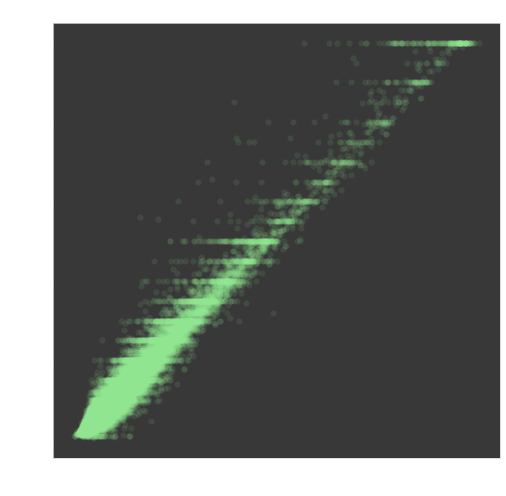

In [0]:
plt.figure(figsize=(8,8))
plt.title("Train Predicted vs Actual")
plt.ylabel('Training Actuals')
plt.xlabel('XGB Predictions')
plt.scatter(training_preds_xgb_reg, y_train ,s=35,alpha=0.1,color='lightgreen',edgecolors='white',linewidths=0.1);

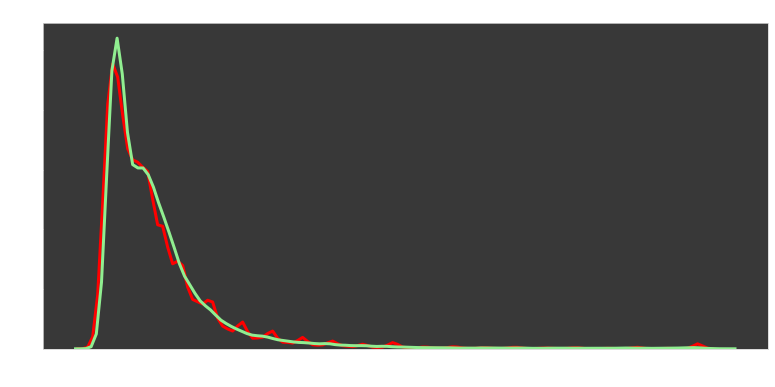

In [0]:
plt.figure(figsize=(13,6))
plt.title('Train Actual vs Predicted')
plt.xlabel('$ Price')
sns.kdeplot(y_train,c='red', linewidth=3);
sns.kdeplot(training_preds_xgb_reg, c='lightgreen', linewidth=3)

In [0]:
pd.DataFrame([ y_train, training_preds_xgb_reg,y_train-training_preds_xgb_reg]).T.sample(20)

,0,1,2
25437,85.0,94.170937,-9.170937
57880,90.0,151.457886,-61.457886
600,140.0,139.512085,0.487915
45914,55.0,59.479679,-4.479679
2956,70.0,109.801964,-39.801964
46375,35.0,39.656590,-4.656590
36630,101.0,95.889511,5.110489
33345,70.0,73.935364,-3.935364
49262,90.0,84.803802,5.196198
28509,165.0,119.080856,45.919144


#### XGB Reg Test Psuedo Residuals




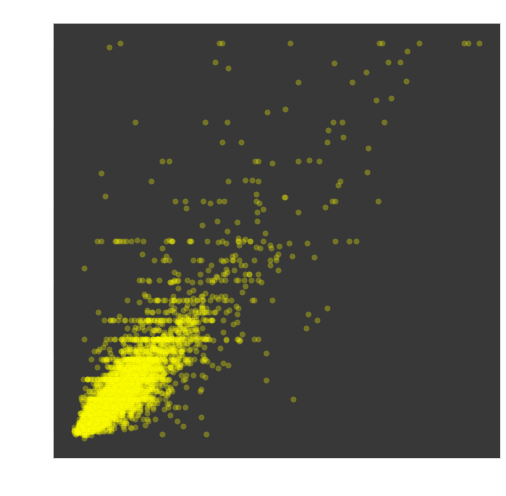

In [0]:
plt.figure(figsize=(8,8))
plt.title("Test Predicted vs Actual")
plt.ylabel('Test Actuals')
plt.xlabel('XGB Predictions')

plt.scatter(test_preds_xgb_reg, y_test,s=35,alpha=0.3,color='yellow',edgecolors='k',linewidths=0.03);

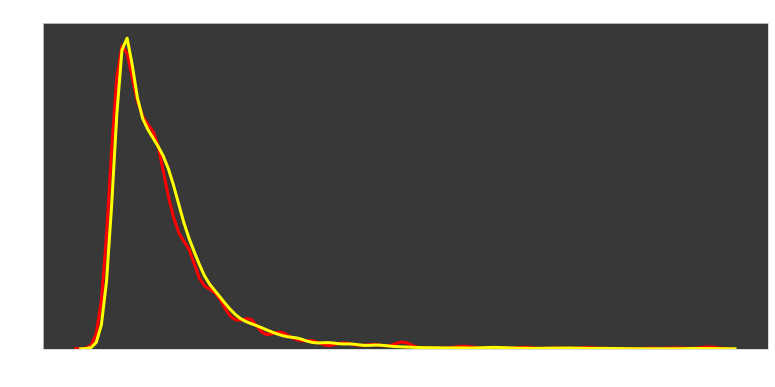

In [0]:
plt.figure(figsize=(13,6))
plt.title('Train Actual vs Predicted')
plt.xlabel('$ Price')
sns.kdeplot(y_test,c='red', linewidth=3)
sns.kdeplot(test_preds_xgb_reg, c='yellow', linewidth=3);

In [0]:
pd.DataFrame([ y_test, test_preds_xgb_reg,y_test-test_preds_xgb_reg, (((y_test/test_preds_xgb_reg)-1))]).T.sample(20)

,0,1,2,3
9548,100.0,135.006714,-35.006714,-0.259296
11188,90.0,103.480759,-13.480759,-0.130273
11744,120.0,106.995422,13.004578,0.121543
2179,450.0,288.969696,161.030304,0.557257
3201,150.0,125.461388,24.538612,0.195587
2751,77.0,160.075439,-83.075439,-0.518977
6923,60.0,54.631115,5.368885,0.098275
8132,120.0,170.513275,-50.513275,-0.296242
4743,23.0,28.339268,-5.339268,-0.188405
8336,69.0,52.774998,16.225002,0.307437


### Tune Parameters

In [0]:
# Parameters that we are going to tune.
params = {
    'max_depth':8,
    'learning_rate':0.1,
    'n_estimators':100,
    'eta':.3,
    'subsample': 0.8,
    'colsample_bytree': 1,
    # Other parameters
    'objective':'reg:squarederror',
    'eval_metric': "mae"
}

num_boost_round = 1000

In [0]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [0]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

[0]	Test-mae:107.743
Will train until Test-mae hasn't improved in 10 rounds.
[1]	Test-mae:102.46
[2]	Test-mae:97.4406


### N Fold Cross-Validate

In [0]:
cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    seed=42,
    nfold=5,
    metrics={'mae'},
    early_stopping_rounds=10
)
cv_results

,train-mae-mean,train-mae-std,test-mae-mean,test-mae-std
0,107.244005,0.176967,107.254900,0.754527
1,101.930268,0.172820,101.953415,0.742637
2,96.889241,0.164694,96.919427,0.737805


In [0]:
cv_results['test-mae-mean'].min()

30.053867599999997

### Parameter Tuning with 5 Fold Cross-Validation

In [0]:
# gridsearch_params = [
#     (max_depth, min_child_weight)
#     for max_depth in range(9,20)
#     for min_child_weight in range(1,)
# ]

gridsearch_params = [
    (max_depth)
    for max_depth in range(8,32)
]

# Define initial best params and MAE
min_mae = float("Inf")
best_params = None
for max_depth in gridsearch_params:
    print("CV with max_depth={}".format(
                             max_depth
                             ))
    # Update parameters
    params['max_depth'] = max_depth
    # params['min_child_weight'] = min_child_weight
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=2,
        metrics={'mae'},
        early_stopping_rounds=10
    )
    # Update best MAE
    mean_mae = cv_results['test-mae-mean'].min()
    boost_rounds = cv_results['test-mae-mean'].argmin()
    print("\tMAE {} for {} rounds".format(mean_mae, boost_rounds))
    if mean_mae < min_mae:
        min_mae = mean_mae
        best_params = (max_depth)
print("Best params: {},  MAE: {}".format(best_params, min_mae))

CV with max_depth=3
	MAE 32.933571 for 710 rounds
CV with max_depth=4
	MAE 32.1732425 for 439 rounds
CV with max_depth=5
	MAE 31.115467000000002 for 573 rounds
CV with max_depth=6
	MAE 30.7644815 for 380 rounds
CV with max_depth=7
	MAE 30.772370000000002 for 236 rounds
CV with max_depth=8
	MAE 30.528756 for 255 rounds
CV with max_depth=9
	MAE 30.4327575 for 225 rounds
CV with max_depth=10
	MAE 30.6706165 for 156 rounds
CV with max_depth=11


KeyboardInterrupt: ignored

## Random Forest Regressor

In [161]:
print(X_train.shape)
s=10000

(60598, 118)


In [166]:
RFR = RandomForestRegressor(max_depth=10, 
                            # min_samples_leaf=100, 
                             min_impurity_split=5,
                             bootstrap=True, 
                             oob_score=True,
                             verbose=True,
                             n_estimators = 20,
                             random_state=123,
                             criterion='mae',
                             n_jobs=-1,)

# RFR = RandomForestRegressor(n_estimators=50, criterion='mae')
RFR.fit(X_train.head(s), y_train[:s])

training_preds_rfr_reg = RFR.predict(X_train.head(s))
test_preds_rfr_reg = RFR.predict(X_test)

print("\nTraining MSE:", round(mean_squared_error(y_train[:s], training_preds_rfr_reg),4))
print("Test MSE:", round(mean_squared_error(y_test, test_preds_rfr_reg),4))
print("\nTraining MAE:", round(mean_absolute_error(y_train[:s], training_preds_rfr_reg),4))
print("Test MAE:", round(mean_absolute_error(y_test, test_preds_rfr_reg),4))
print("\nTraining r2:", round(r2_score(y_train[:s], training_preds_rfr_reg),4))
print("Test r2:", round(r2_score(y_test, test_preds_rfr_reg),4))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  1.1min finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    0.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  20 out of  20 | elapsed:    0.0s finished



Training MSE: 3800.0092
Test MSE: 5100.8956

Training MAE: 28.8077
Test MAE: 35.7916

Training r2: 0.7189
Test r2: 0.5679


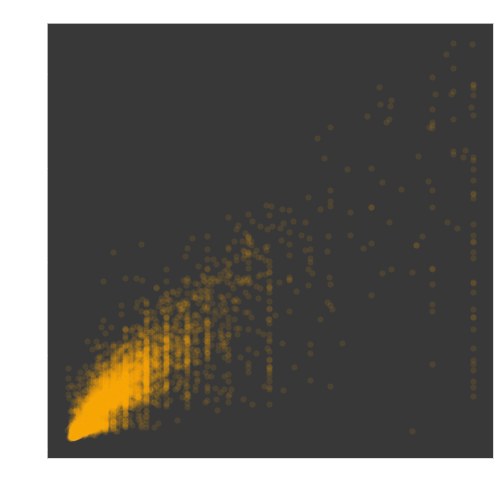

In [167]:
plt.figure(figsize=(8,8))
plt.title("RFR Train Predicted vs Actual")
plt.ylabel('RFR Training Actuals')
plt.xlabel('RFR Predictions')
plt.scatter(y_train[:s], training_preds_rfr_reg ,s=35,alpha=0.1,color='orange',edgecolors='white',linewidths=0.1);

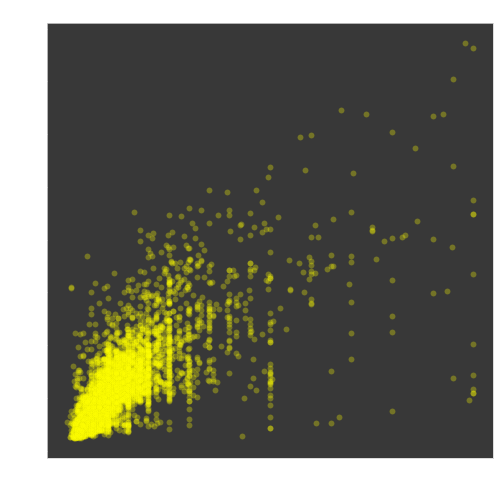

In [168]:
plt.figure(figsize=(8,8))
plt.title("RFR Test Predicted vs Actual")
plt.ylabel('RFR Test Actuals')
plt.xlabel('RFR Predictions')

plt.scatter(y_test, test_preds_rfr_reg,s=35,alpha=0.3,color='yellow',edgecolors='k',linewidths=0.03);

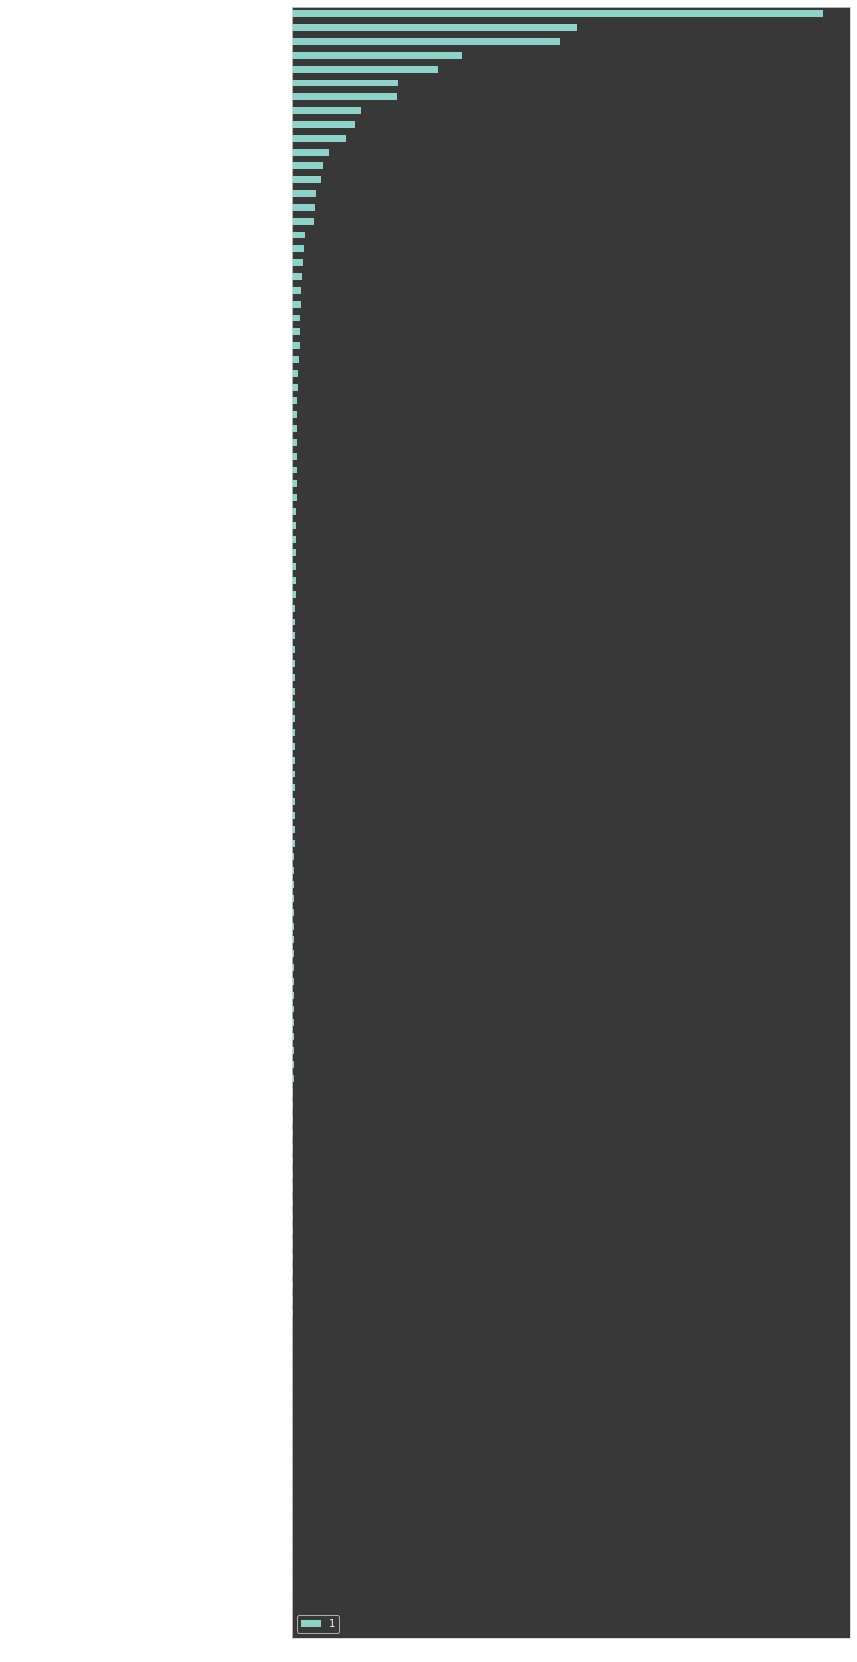

In [165]:
pd.DataFrame([X.columns,RFR.feature_importances_]).T.sort_values(by=1,ascending=True).set_index(0).plot(kind='barh', figsize=(10,30));

## 3 Layer ADAM NN

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 128)               15616     
_________________________________________________________________
dense_10 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_11 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 257       
Total params: 114,689
Trainable params: 114,689
Non-trainable params: 0
_________________________________________________________________
None


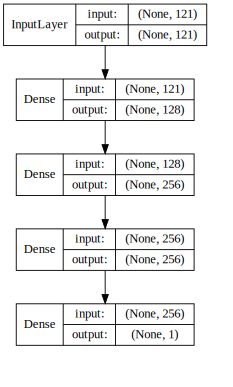

In [0]:
# Building the model
nn2 = models.Sequential()
nn2.add(layers.Dense(128, input_shape=(X_train.shape[1],), activation='relu'))
nn2.add(layers.Dense(256, activation='relu'))
nn2.add(layers.Dense(256, activation='relu'))
nn2.add(layers.Dense(1, activation='linear'))

# Compiling the model
nn2.compile(loss='mean_absolute_error',
            optimizer='adam',
            metrics=['mean_absolute_error'])

# Model summary
print(nn2.summary())

# Visualising the neural network
SVG(model_to_dot(nn2, show_layer_names=False, show_shapes=True, dpi=65).create(prog='dot', format='svg'))

In [0]:
# Training the model
nn2_start = time.time()

nn2_history = nn2.fit(X_train,
                  y_train,
                  epochs=100,
                  batch_size=256,
                  validation_split = 0.10)

nn2_end = time.time()

print(f"Time taken to run: {round((nn2_end - nn2_start)/60,1)} minutes")




Train on 60598 samples, validate on 6734 samples
Epoch 1/100





60598/60598 [==============================] - 2s 37us/step - loss: 43.7481 - mean_absolute_error: 43.7481 - val_loss: 35.2087 - val_mean_absolute_error: 35.2087
Epoch 2/100
60598/60598 [==============================] - 1s 24us/step - loss: 34.8519 - mean_absolute_error: 34.8519 - val_loss: 34.5161 - val_mean_absolute_error: 34.5161
Epoch 3/100
60598/60598 [==============================] - 1s 24us/step - loss: 33.9071 - mean_absolute_error: 33.9071 - val_loss: 33.6494 - val_mean_absolute_error: 33.6494
Epoch 4/100
60598/60598 [==============================] - 1s 25us/step - loss: 33.0527 - mean_absolute_error: 33.0527 - val_loss: 33.0495 - val_mean_absolute_error: 33.0495
Epoch 5/100
60598/60598 [==============================] - 1s 24us/step - loss: 32.2879 - mean_absolute_error: 32.2879 - val_loss: 32.6196 - val_mean_absolute_error: 32.6196
Epoch 6/100
60598/60598 [==============================] - 2s 25us/step -

In [0]:
def nn_model_evaluation(model, skip_epochs=0, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test):
    """
    For a given neural network model that has already been fit, prints for the train and tests sets the MSE and r squared
    values, a line graph of the loss in each epoch, and a scatterplot of predicted vs. actual values with a line
    representing where predicted = actual values. Optionally, a value for skip_epoch can be provided, which skips that
    number of epochs in the line graph of losses (useful in cases where the loss in the first epoch is orders of magnitude
    larger than subsequent epochs). Training and test sets can also optionally be specified.
    """

    # MSE and r squared values
    y_test_pred = model.predict(X_test)
    y_train_pred = model.predict(X_train)
    print("Training MAE:", round(mean_absolute_error(y_train, y_train_pred),4))
    print("Validation MAE:", round(mean_absolute_error(y_test, y_test_pred),4))
    print("\nTraining r2:", round(r2_score(y_train, y_train_pred),4))
    print("Validation r2:", round(r2_score(y_test, y_test_pred),4))
    
    # Line graph of losses
    model_results = model.history.history
    plt.plot(list(range((skip_epochs+1),len(model_results['loss'])+1)), model_results['loss'][skip_epochs:], label='Train')
    plt.plot(list(range((skip_epochs+1),len(model_results['val_loss'])+1)), model_results['val_loss'][skip_epochs:], label='Test', color='green')
    plt.legend()
    plt.title('Training and test loss at each epoch', fontsize=14)
    plt.show()
    
    # Scatterplot of predicted vs. actual values
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle('Predicted vs. actual values', fontsize=14, y=1)
    plt.subplots_adjust(top=0.93, wspace=0)
    
    ax1.scatter(y_test, y_test_pred, s=2, alpha=0.7)
    ax1.plot(list(range(2,8)), list(range(2,8)), color='black', linestyle='--')
    ax1.set_title('Test set')
    ax1.set_xlabel('Actual values')
    ax1.set_ylabel('Predicted values')
    
    ax2.scatter(y_train, y_train_pred, s=2, alpha=0.7)
    ax2.plot(list(range(2,8)), list(range(2,8)), color='black', linestyle='--')
    ax2.set_title('Train set')
    ax2.set_xlabel('Actual values')
    ax2.set_ylabel('')
    ax2.set_yticklabels(labels='')
    
    plt.show()

Training MAE: 16.1288
Validation MAE: 36.5911

Training r2: 0.869
Validation r2: -1.1024


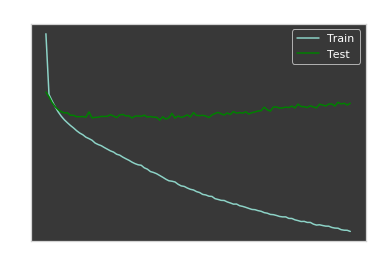

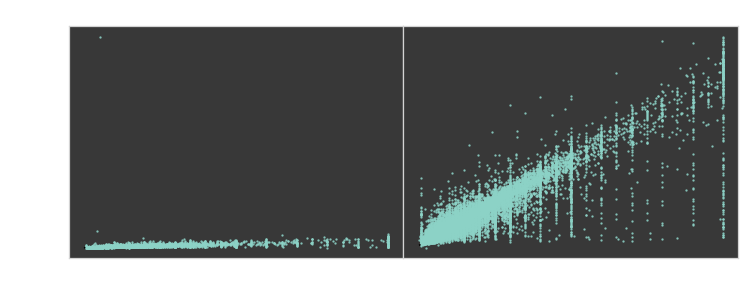

In [0]:
nn_model_evaluation(nn2)

## 3 Layer NN with Dropout Regularization

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_13 (Dropout)         (None, 121)               0         
_________________________________________________________________
dense_35 (Dense)             (None, 128)               15616     
_________________________________________________________________
dropout_14 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_36 (Dense)             (None, 256)               33024     
_________________________________________________________________
dropout_15 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_37 (Dense)             (None, 512)               131584    
_________________________________________________________________
dropout_16 (Dropout)         (None, 512)              

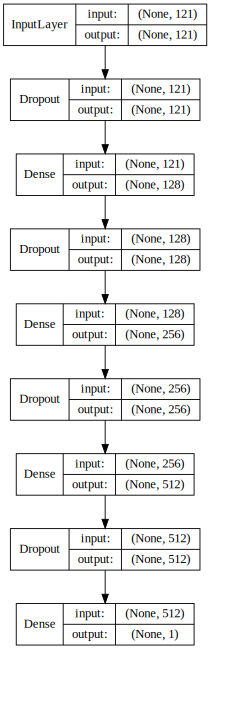

In [0]:
# Building the model
NND = models.Sequential()
NND.add(layers.Dropout(0.5, input_shape=(X_train.shape[1],)))
NND.add(layers.Dense(128, activation='relu'))
NND.add(layers.Dropout(0.5))
NND.add(layers.Dense(256, activation='relu'))
NND.add(layers.Dropout(0.5))
NND.add(layers.Dense(512, activation='relu'))
NND.add(layers.Dropout(0.5))
NND.add(layers.Dense(1, activation='linear'))

# Compiling the model
NND.compile(loss='mean_absolute_error',
            optimizer='adam',
            metrics=['mean_absolute_error'])

# Model summary
print(NND.summary())

# Visualising the neural network
SVG(model_to_dot(NND, show_layer_names=False, show_shapes=True,dpi=65).create(prog='dot', format='svg'))
# SVG(model_to_dot(nn4, show_layer_names=False, show_shapes=True, dpi=65).create(prog='dot', format='svg'))

In [0]:
# Training the model
NND_start = time.time()

NND_history = nn5.fit(X_train,
                  y_train,
                  epochs=50,
                  batch_size=256,
                  validation_split = 0.1)

NND_end = time.time()

print(f"Time taken to run: {round((NND_end - NND_start)/60,1)} minutes")

Train on 60598 samples, validate on 6734 samples
Epoch 1/50
60598/60598 [==============================] - 4s 64us/step - loss: 52.8754 - mean_absolute_error: 52.8754 - val_loss: 45.2150 - val_mean_absolute_error: 45.2150
Epoch 2/50
60598/60598 [==============================] - 3s 50us/step - loss: 46.2130 - mean_absolute_error: 46.2130 - val_loss: 47.3470 - val_mean_absolute_error: 47.3470
Epoch 3/50
50944/60598 [========================>.....] - ETA: 0s - loss: 45.4740 - mean_absolute_error: 45.4740

KeyboardInterrupt: ignored

Training MSE: 9147.2914
Validation MSE: 10697.9227

Training r2: 0.2845
Validation r2: 0.2463


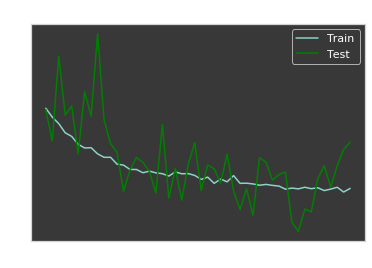

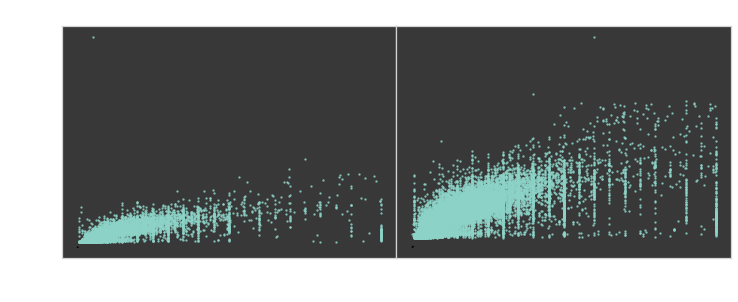

In [0]:
nn_model_evaluation(NND, skip_epochs=2)

## Explore Variable Importance With Shapely Values
Documentation: <a href="https://github.com/slundberg/shap">github</a>

In [0]:
!pip install lime
!pip install shap

In [0]:
import shap

# Tree on XGBoost
explainerXGB = shap.TreeExplainer(xgb_reg)
shap_values_XGB_test = explainerXGB.shap_values(X_test)
shap_values_XGB_train = explainerXGB.shap_values(X_train)

In [0]:
# XGBoost
df_shap_XGB_test = pd.DataFrame(shap_values_XGB_test, columns=X_test.columns.values)
df_shap_XGB_train = pd.DataFrame(shap_values_XGB_train, columns=X_train.columns.values)
# # Scikit GBT
# df_shap_SKGBT_test = pd.DataFrame(shap_values_SKGBT_test, columns=X_test.columns.values)
# df_shap_SKGBT_train = pd.DataFrame(shap_values_SKGBT_train, columns=X_train.columns.values)
# # Random Forest
# df_shap_RF_test = pd.DataFrame(shap_values_RF_test, columns=X_test.columns.values)
# df_shap_RF_train = pd.DataFrame(shap_values_RF_train, columns=X_train.columns.values)
# # KNN
# df_shap_KNN_test = pd.DataFrame(shap_values_KNN_test, columns=X_test.columns.values)
# df_shap_KNN_train = pd.DataFrame(shap_values_KNN_train, columns=X_train.columns.values)

In [0]:
# j will be the record we explain
j = 0



In [0]:
shap.initjs()

print("Actual Value: {}".format(y_test[j]))
shap.force_plot(explainerXGB.expected_value, shap_values_XGB_test[j], X_test.iloc[[j]])



Actual Value: 349


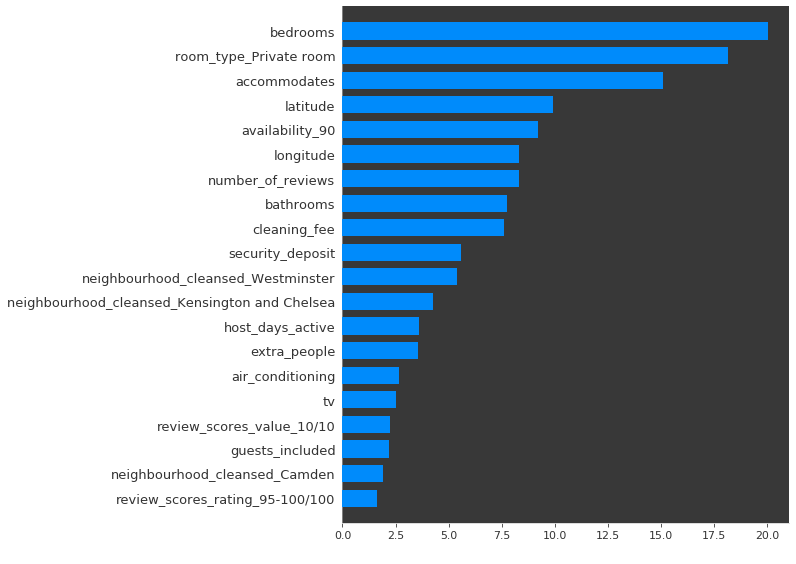

In [0]:
shap.summary_plot(shap_values_XGB_train, X_train, plot_type="bar")


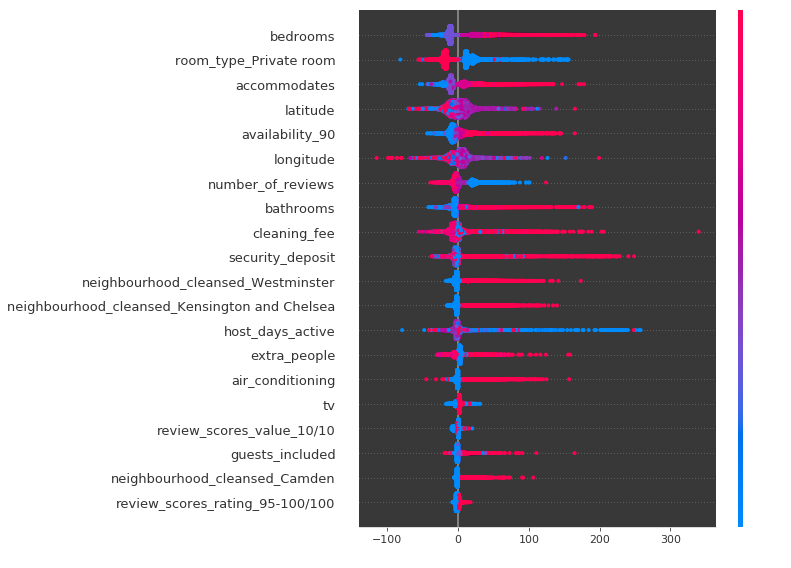

In [0]:
shap.summary_plot(shap_values_XGB_train, X_train)

<Figure size 720x720 with 0 Axes>

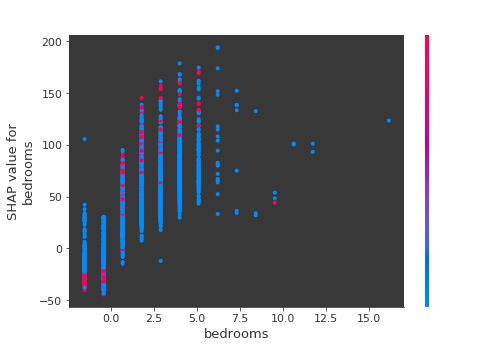

In [0]:
plt.figure(figsize=(10,10))
shp_plt = shap.dependence_plot("bedrooms", shap_values_XGB_train, X_train,co)


In [0]:
shap.initjs()
shap_values = explainerXGB.shap_values(X_test)
shap.force_plot(explainerXGB.expected_value,p_values, X_test)

NameError: ignored